In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, BatchNormalization, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from wordcloud import WordCloud,STOPWORDS

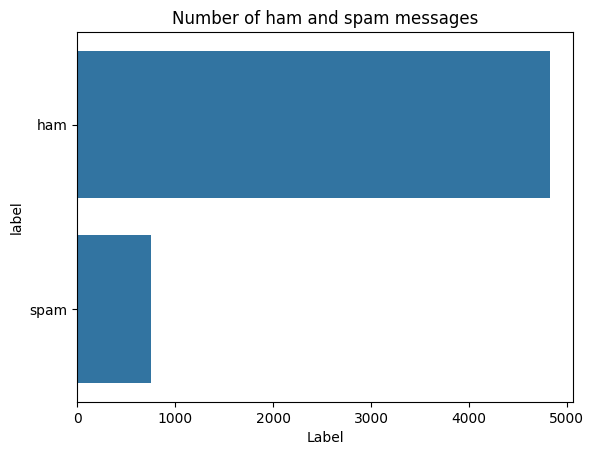

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [4]:

#read in data using pandas
train_df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Deep Learning/Task 5/spam.csv", delimiter=',', encoding='latin-1')
train_df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
train_df.columns = ['label', 'text']
sns.countplot(train_df.label)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')
plt.show()
classification = ['ham', 'spam']
#check data has been read in properly
train_df.head()
train_df.info()

# syntaxes

In [5]:
import re
#Removes Punctuations
def remove_punctuations(data):
    punct_tag=re.compile(r'[^\w\s]')
    data=punct_tag.sub(r'',data)
    return data

#Removes HTML syntaxes
def remove_html(data):
    html_tag=re.compile(r'<.*?>')
    data=html_tag.sub(r'',data)
    return data

#Removes URL data
def remove_url(data):
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data

#Removes Emojis
def remove_emoji(data):
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    data=emoji_clean.sub(r'',data)
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data

In [6]:
#train_df['text'], train_df['label']
train_df['text'] = train_df['text'].apply(lambda z: remove_punctuations(z))
train_df['text'] = train_df['text'].apply(lambda z: remove_html(z))
train_df['text'] = train_df['text'].apply(lambda z: remove_url(z))
train_df['text'] = train_df['text'].apply(lambda z: remove_emoji(z))

In [7]:
# Об'єднання всіх текстів із тренувальної вибірки в один рядок
def display_cloud(data):
    text = " ".join(review for review in data)

    # Створення об'єкта WordCloud з налаштуваннями
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(text)

    # Візуалізація WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

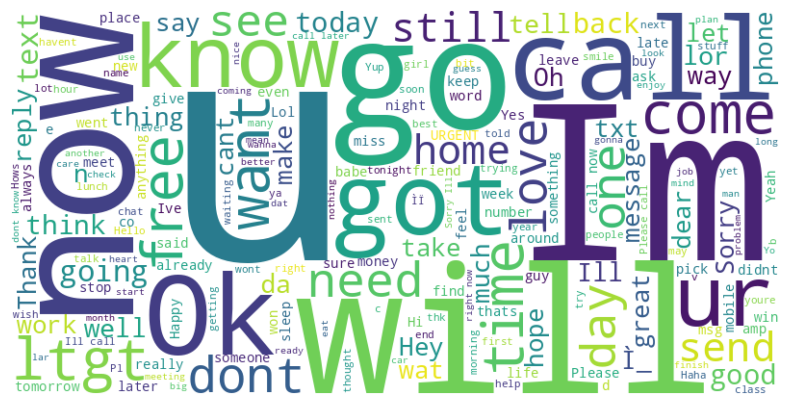

In [8]:
display_cloud(train_df['text'])

# worked

In [9]:
from collections import Counter
word_counts = Counter(" ".join(train_df['text']).split())
total_words = sum(word_counts.values())
common_words = sum([count for _, count in word_counts.most_common(1700)])
coverage = common_words / total_words
print(f"Покриття словника: {coverage * 100:.2f}%")


Покриття словника: 80.51%


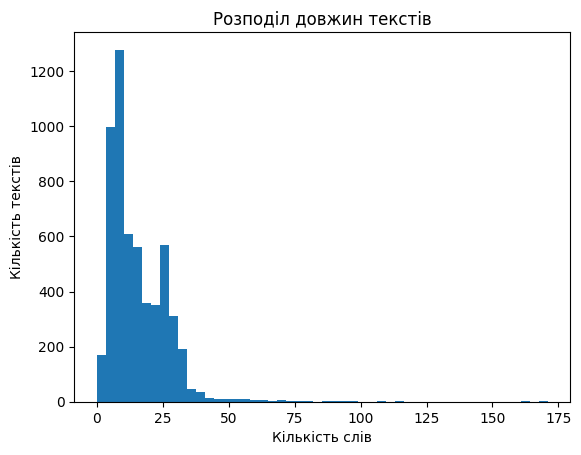

In [10]:
lengths = [len(text.split()) for text in train_df['text']]
plt.hist(lengths, bins=50)
plt.title("Розподіл довжин текстів")
plt.xlabel("Кількість слів")
plt.ylabel("Кількість текстів")
plt.show()


In [11]:
import numpy as np
percentiles = np.percentile(lengths, [80, 90, 95])
print(f"80-й перцентиль: {percentiles[0]}")
print(f"90-й перцентиль: {percentiles[1]}")
print(f"95-й перцентиль: {percentiles[2]}")

80-й перцентиль: 25.0
90-й перцентиль: 28.0
95-й перцентиль: 32.0


In [12]:
max_words = 1700
max_len = 29

In [13]:
le = LabelEncoder()
Y = le.fit_transform(train_df['label'])
Y = pd.DataFrame(Y.reshape(-1, 1))
Y.head(n=10)

,0
0,0
1,0
2,1
3,0
4,0
5,1
6,0
7,0
8,1
9,1


In [14]:
X_train, X_temp, Y_train, Y_temp = train_test_split(train_df['text'], Y, test_size=0.3, stratify=Y, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.3, stratify=Y_temp, random_state=42)

# Calculate sizes
total_size = len(train_df['text'])
train_size = len(X_train)
val_size = len(X_val)
test_size = len(X_test)

# Calculate percentages
train_percent = (train_size / total_size) * 100
val_percent = (val_size / total_size) * 100
test_percent = (test_size / total_size) * 100

# Print the shapes and percentages
print(f"X_train shape: {X_train.shape}, {train_percent:.2f}% of total data")
print(f"X_val shape: {X_val.shape}, {val_percent:.2f}% of total data")
print(f"X_test shape: {X_test.shape}, {test_percent:.2f}% of total data")

# Check the distribution in the original dataset
print("Original dataset distribution:")
print(Y.value_counts(normalize=True))

# Check the distribution in the training set
print("\nTraining set distribution:")
print(Y_train.value_counts(normalize=True))

# Check the distribution in the validation set
print("\nValidation set distribution:")
print(Y_val.value_counts(normalize=True))

# Check the distribution in the test set
print("\nTest set distribution:")
print(Y_test.value_counts(normalize=True))

X_train shape: (3900,), 69.99% of total data
X_val shape: (1170,), 21.00% of total data
X_test shape: (502,), 9.01% of total data
Original dataset distribution:
0
0    0.865937
1    0.134063
Name: proportion, dtype: float64

Training set distribution:
0
0    0.865897
1    0.134103
Name: proportion, dtype: float64

Validation set distribution:
0
0    0.865812
1    0.134188
Name: proportion, dtype: float64

Test set distribution:
0
0    0.866534
1    0.133466
Name: proportion, dtype: float64


In [15]:
# Define tokenizer
tok = Tokenizer(num_words=max_words)

# Fit tokenizer on training data
tok.fit_on_texts(X_train)

# Transform texts to sequences
train_sequences = tok.texts_to_sequences(X_train)
val_sequences = tok.texts_to_sequences(X_val)
test_sequences = tok.texts_to_sequences(X_test)

# Pad sequences
X_train_vectorized = pd.DataFrame(sequence.pad_sequences(train_sequences, maxlen=max_len))
X_val_vectorized = pd.DataFrame(sequence.pad_sequences(val_sequences, maxlen=max_len))
X_test_vectorized = pd.DataFrame(sequence.pad_sequences(test_sequences, maxlen=max_len))

# Print shapes to verify
print(f"X_train_vectorized shape: {X_train_vectorized.shape}")
print(f"X_val_vectorized shape: {X_val_vectorized.shape}")
print(f"X_test_vectorized shape: {X_test_vectorized.shape}")


X_train_vectorized shape: (3900, 29)
X_val_vectorized shape: (1170, 29)
X_test_vectorized shape: (502, 29)


In [16]:
X_train_vectorized

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0,0,0,0,0,0,0,0,0,0,...,49,4,748,73,1,126,4,25,158,254
1,0,0,0,0,0,0,0,0,0,0,...,44,28,3,68,14,1,10,414,255,884
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,255,12
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,108,194,2,36,64,138
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,306,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,139,315,1,601,15
3896,0,0,0,0,0,0,0,0,0,0,...,101,222,1,86,6,168,249,539,15,39
3897,0,0,0,0,0,0,0,0,0,0,...,2,32,109,49,3,19,43,7,1,4
3898,0,340,24,38,369,510,6,165,151,181,...,134,658,23,96,26,76,53,369,17,82


## function

In [17]:
def plot_visualization(history):
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

## model

In [18]:
def RNN1():
    inputs = Input(name='inputs', shape=[max_len])
    layer = Embedding(max_words, 50, input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256)(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1, name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs, outputs=layer)
    return model

In [19]:
def RNN2():
    inputs = Input(name='inputs', shape=[max_len])
    layer = Embedding(input_dim=max_words, output_dim=50, input_length=max_len)(inputs)
    layer = LSTM(64, dropout=0.2)(layer)
    layer = Dense(128, kernel_regularizer=l2(0.001))(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1, name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs, outputs=layer)
    return model


In [20]:
def RNN3_improved():
    inputs = Input(name='inputs', shape=[max_len])

    # Embedding layer with dropout
    layer = Embedding(input_dim=max_words, output_dim=100, input_length=max_len)(inputs)  # Increase embedding dim
    layer = Dropout(0.3)(layer)  # Regularization in embedding

    # Bidirectional LSTM with dropout
    layer = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))(layer)

    # Attention layer
    attention = tf.keras.layers.Attention()([layer, layer])  # Self-attention
    layer = tf.keras.layers.Flatten()(attention)  # Flatten for dense layers

    # Fully connected layers
    layer = Dense(128, name='FC1', kernel_regularizer=l2(0.001))(layer)
    layer = BatchNormalization()(layer)  # Batch normalization
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)  # Increase dropout for stronger regularization

    layer = Dense(64, name='FC2', kernel_regularizer=l2(0.001))(layer)
    layer = BatchNormalization()(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.4)(layer)

    # Output layer
    layer = Dense(1, name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)  # Binary classification

    # Compile model
    model = Model(inputs=inputs, outputs=layer)
    return model

In [21]:
def RNN4():
    inputs = Input(name='inputs', shape=[max_len])
    layer = Embedding(input_dim=max_words, output_dim=128, input_length=max_len)(inputs)
    layer = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))(layer)
    layer = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))(layer)

    layer = Dense(128, name='FC1', kernel_regularizer=l2(0.001))(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1, name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs, outputs=layer)
    return model


## tuple

In [42]:
train_dataset, val_dataset, test_dataset = (X_train_vectorized,Y_train), (X_val_vectorized, Y_val), (X_test_vectorized,Y_test)
test_dataset[0]

array([[   0,    0,    0, ...,   22,    4,  310],
       [   0,    0,    0, ...,   17,    3,   91],
       [   0,    0,    0, ...,   12, 1674,    8],
       ...,
       [   0,    0,    0, ...,    1,   32,  118],
       [   0,    0,    0, ...,   85,  230,  580],
       [   0,    0,    0, ...,   56,   19,  702]], dtype=int32)

In [41]:
def training_RNN(model, train_dataset, val_dataset, test_dataset, epochs=5):
    print(f"Training model RNN")

    # Optimizer setup
    optimizer = Adam(0.001, beta_1=0.9, beta_2=0.999)

    # Compile the model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    # Compute class weights
    from sklearn.utils.class_weight import compute_class_weight
    y_train = train_dataset[1].to_numpy().ravel()  # Convert y_train to 1D array if needed
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights = dict(enumerate(class_weights))

    # Callbacks
    early_stopping_monitor = EarlyStopping(patience=3, monitor='val_loss', min_delta=0.0001, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                                  patience=1,
                                  verbose=1,
                                  factor=0.5,
                                  min_lr=1e-6)

    # Train the model
    history = model.fit(
        train_dataset[0],
        y_train,
        validation_data=val_dataset,
        batch_size=64,
        epochs=epochs,
        class_weight=class_weights,  # Use computed class weights
        callbacks=[reduce_lr, early_stopping_monitor]
    )

    # Plot training visualization
    plot_visualization(history)

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(test_dataset[0], test_dataset[1])
    #precision, recall, f1 = calculate_metrics(model, test_dataset)
    #plot_confusion_matrix(test_dataset, classification, 'training')
    y_pred = model.predict(test_dataset[0]) > 0.5

    # Classification report
    print(classification_report(test_dataset[1], y_pred, target_names=classification))

    # Confusion Matrix
    cm = confusion_matrix(test_dataset[1], y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classification)
    disp.plot(cmap='Greens')
    plt.show()

    # Print metrics
    #print(f"Test Accuracy: {test_accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")
    print("-" * 60)


Training model RNN


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)                  │ (None, 29)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 29, 50)              │          85,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          29,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC1 (Dense)                          │ (None, 256)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ out_layer (Dense)                    │ (None, 1)                   │             257 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 131,337 (513.04 KB)

 Trainable params: 131,337 (513.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.8138 - loss: 0.5719 - val_accuracy: 0.9709 - val_loss: 0.1871 - learning_rate: 0.0010
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9724 - loss: 0.1445
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9724 - loss: 0.1443 - val_accuracy: 0.9462 - val_loss: 0.1694 - learning_rate: 0.0010
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9762 - loss: 0.0870 - val_accuracy: 0.9803 - val_loss: 0.0776 - learning_rate: 5.0000e-04
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9906 - loss: 0.0542 - val_accuracy: 0.9829 - val_loss: 0.0654 - learning_rate: 5.0000e-04
Epoch 5/10
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9949 - loss: 0.0260
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9947 - loss: 0.0268 - v

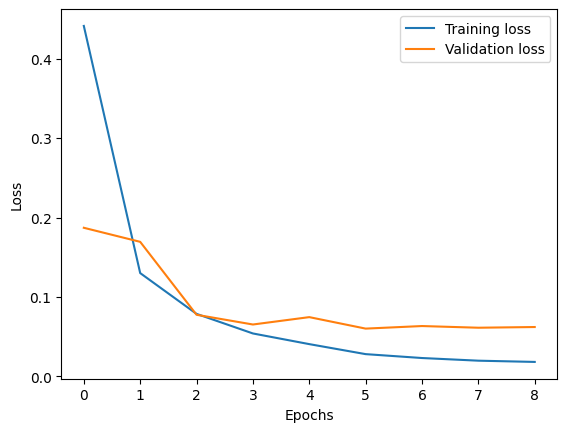

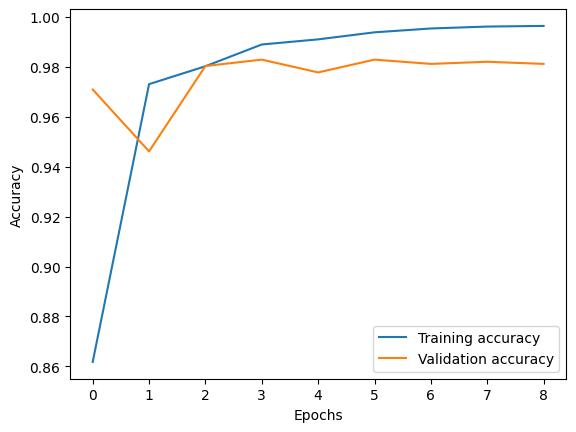

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9710 - loss: 0.0931
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       435
        spam       0.97      0.88      0.92        67

    accuracy                           0.98       502
   macro avg       0.97      0.94      0.96       502
weighted avg       0.98      0.98      0.98       502



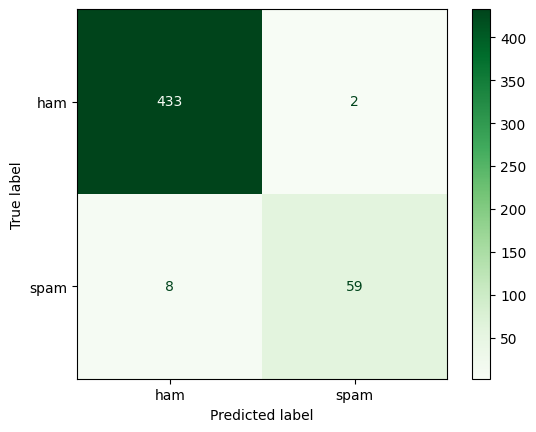

------------------------------------------------------------


In [24]:
model = RNN1()
training_RNN(model, train_dataset, val_dataset, test_dataset, epochs=10)

Training model RNN


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)                  │ (None, 29)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 29, 50)              │          85,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          29,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC1 (Dense)                          │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ out_layer (Dense)                    │ (None, 1)                   │             129 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,889 (480.04 KB)

 Trainable params: 122,889 (480.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.8039 - loss: 0.6711 - val_accuracy: 0.9675 - val_loss: 0.2306 - learning_rate: 0.0010
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9728 - loss: 0.2143 - val_accuracy: 0.9726 - val_loss: 0.1558 - learning_rate: 0.0010
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9794 - loss: 0.1456 - val_accuracy: 0.9855 - val_loss: 0.0940 - learning_rate: 0.0010
Epoch 4/10
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9818 - loss: 0.1040
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9820 - loss: 0.1037 - val_accuracy: 0.9752 - val_loss: 0.1073 - learning_rate: 0.0010
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9877 - loss: 0.0711
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9878 - loss: 0.0711 - val_accur

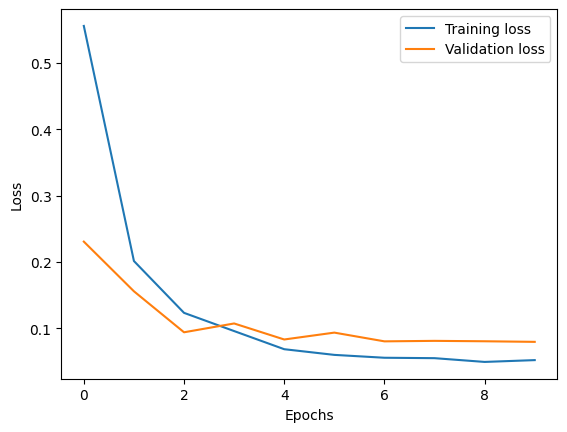

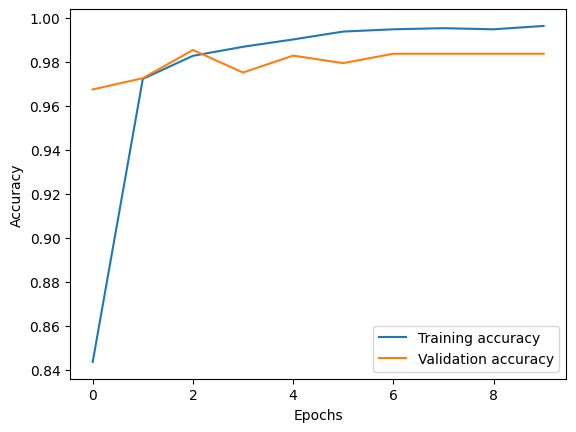

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9813 - loss: 0.1098
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       435
        spam       0.98      0.91      0.95        67

    accuracy                           0.99       502
   macro avg       0.99      0.95      0.97       502
weighted avg       0.99      0.99      0.99       502



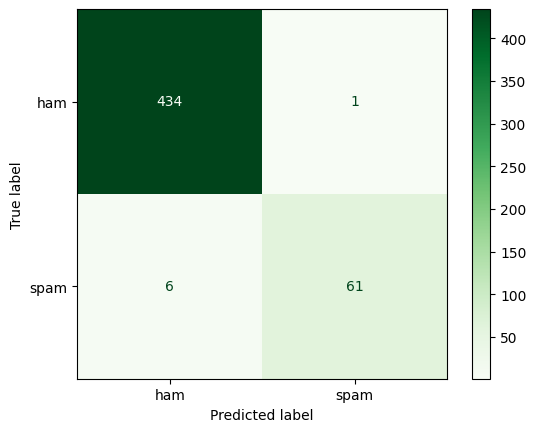

------------------------------------------------------------


In [25]:
model = RNN2()
training_RNN(model, train_dataset, val_dataset, test_dataset, epochs=10)

Training model RNN


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)       │ (None, 29)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 29, 100)        │        170,000 │ inputs[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 29, 100)        │              0 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 29, 128)        │         84,480 │ dropout_2[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 29, 128)        │              0 │ bidirectional[0][0],   │
│                           │                        │                │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 3712)           │              0 │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ FC1 (Dense)               │ (None, 128)            │        475,264 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128)            │            512 │ FC1[0][0]              │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activation) │ (None, 128)            │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 128)            │              0 │ activation_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ FC2 (Dense)               │ (None, 64)             │          8,256 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64)             │            256 │ FC2[0][0]              │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_5 (Activation) │ (None, 64)             │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 64)             │              0 │ activation_5[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ out_layer (Dense)         │ (None, 1)              │             65 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_6 (Activation) │ (None, 1)              │              0 │ out_layer[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 738,833 (2.82 MB)

 Trainable params: 738,449 (2.82 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 22s 272ms/step - accuracy: 0.6726 - loss: 0.8745 - val_accuracy: 0.9786 - val_loss: 0.7696 - learning_rate: 0.0010
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 17s 217ms/step - accuracy: 0.9539 - loss: 0.4732 - val_accuracy: 0.9855 - val_loss: 0.4954 - learning_rate: 0.0010
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.9676 - loss: 0.3622
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
61/61 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - accuracy: 0.9677 - loss: 0.3621 - val_accuracy: 0.9838 - val_loss: 0.3575 - learning_rate: 0.0010
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9792 - loss: 0.2895
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
61/61 ━━━━━━━━━━━━━━━━━━━━ 14s 96ms/step - accuracy: 0.9792 - loss: 0.2894 - val_accuracy: 0.9838 - val_loss: 0.3301 - learning_rate: 5.0000e-04
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - accuracy: 0.9708 - loss: 0.27

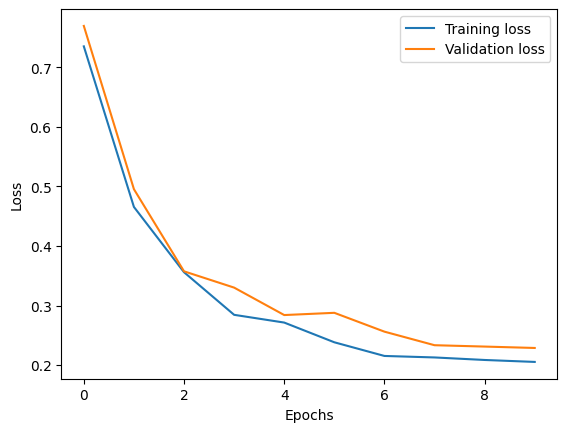

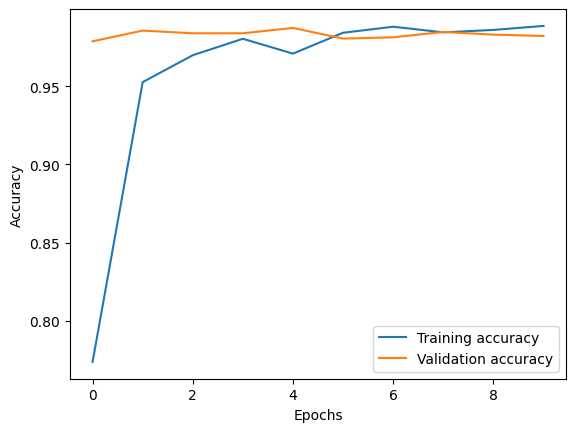

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9813 - loss: 0.2444
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       435
        spam       0.98      0.91      0.95        67

    accuracy                           0.99       502
   macro avg       0.99      0.95      0.97       502
weighted avg       0.99      0.99      0.99       502



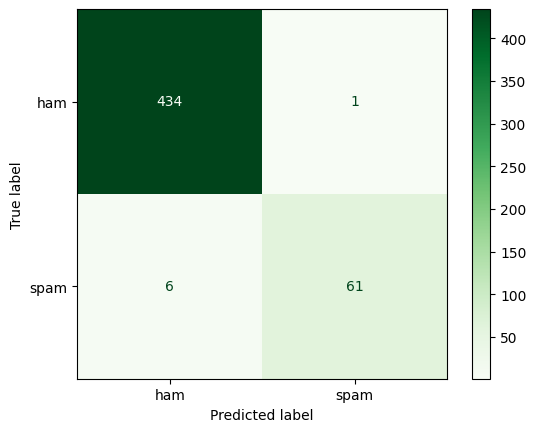

------------------------------------------------------------


In [26]:
model = RNN3_improved()
training_RNN(model, train_dataset, val_dataset, test_dataset, epochs=10)

Training model RNN


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)                  │ (None, 29)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_4 (Embedding)              │ (None, 29, 128)             │         217,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 29, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC1 (Dense)                          │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ out_layer (Dense)                    │ (None, 1)                   │             129 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 431,873 (1.65 MB)

 Trainable params: 431,873 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - accuracy: 0.8459 - loss: 0.6246 - val_accuracy: 0.9778 - val_loss: 0.1882 - learning_rate: 0.0010
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.9809 - loss: 0.1803 - val_accuracy: 0.9803 - val_loss: 0.1272 - learning_rate: 0.0010
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 12s 192ms/step - accuracy: 0.9863 - loss: 0.1141 - val_accuracy: 0.9812 - val_loss: 0.1021 - learning_rate: 0.0010
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9949 - loss: 0.0726
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
61/61 ━━━━━━━━━━━━━━━━━━━━ 19s 169ms/step - accuracy: 0.9949 - loss: 0.0727 - val_accuracy: 0.9803 - val_loss: 0.1029 - learning_rate: 0.0010
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9977 - loss: 0.0512
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 241ms/step - accuracy: 0.9977 - loss: 0.0513 

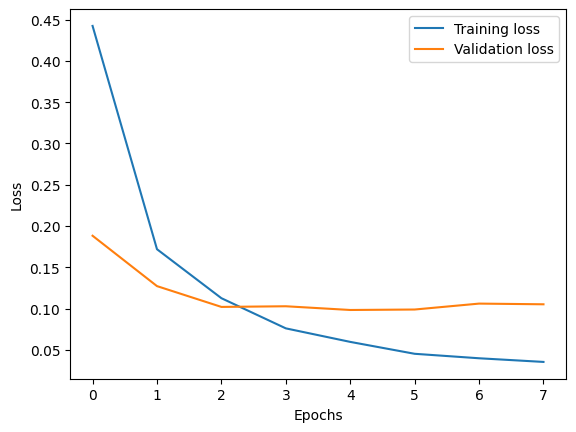

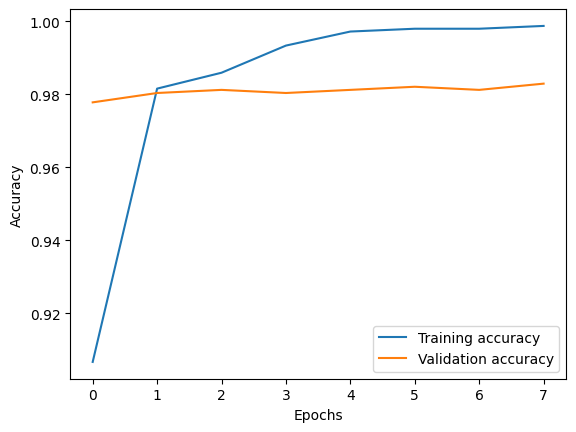

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9792 - loss: 0.1178
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       435
        spam       0.97      0.90      0.93        67

    accuracy                           0.98       502
   macro avg       0.98      0.95      0.96       502
weighted avg       0.98      0.98      0.98       502



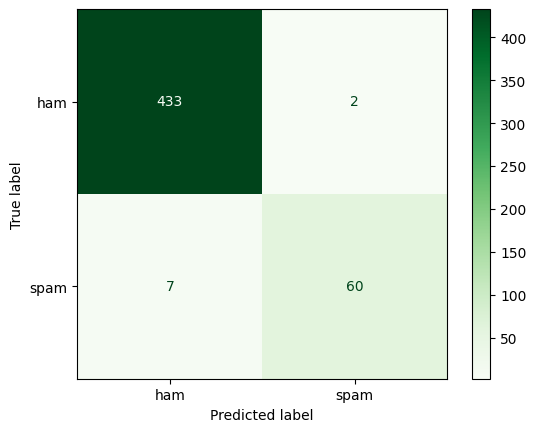

------------------------------------------------------------


In [43]:
model = RNN4()
training_RNN(model, train_dataset, val_dataset, test_dataset, epochs=10)

# Test

In [ ]:
def predict_model(model, tf_dataset):
    Y_pred = model.predict(tf_dataset, verbose=0)
    Y_pred_classes = np.argmax(Y_pred, axis=1)
    Y_true = np.concatenate([y for x, y in tf_dataset], axis=0)
    return Y_true, Y_pred_classes

In [28]:
le = LabelEncoder()
Y = le.fit_transform(train_df['label'])
Y = Y.reshape(-1, 1)

In [29]:
def make_dataset(ndarrayX, ndarrayY, drop_remainder=False, batch_size=256):

    ds_x = tf.data.Dataset.from_tensor_slices(ndarrayX)
    ds_y = tf.data.Dataset.from_tensor_slices(ndarrayY)

    ds = tf.data.Dataset.zip((ds_x, ds_y))

    if batch_size:
        ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    return ds

In [30]:
# Define tokenizer
tok = Tokenizer(num_words=max_words)

# Fit tokenizer on training data
tok.fit_on_texts(X_train)

# Transform texts to sequences
train_sequences = tok.texts_to_sequences(X_train)
val_sequences = tok.texts_to_sequences(X_val)
test_sequences = tok.texts_to_sequences(X_test)

# Pad sequences
X_train_vectorized = sequence.pad_sequences(train_sequences, maxlen=max_len)
X_val_vectorized = sequence.pad_sequences(val_sequences, maxlen=max_len)
X_test_vectorized = sequence.pad_sequences(test_sequences, maxlen=max_len)

# Print shapes to verify
print(f"X_train_vectorized shape: {X_train_vectorized.shape}")
print(f"X_val_vectorized shape: {X_val_vectorized.shape}")
print(f"X_test_vectorized shape: {X_test_vectorized.shape}")


X_train_vectorized shape: (3900, 29)
X_val_vectorized shape: (1170, 29)
X_test_vectorized shape: (502, 29)


In [31]:
val_dataset

(      0   1   2    3   4    5    6    7   8    9   ...   19    20   21    22  \
 0      0   0   0    0   0    0    0    0   0    0  ...  115     4  409  1556   
 1      0   0   0    0   0    6  155  473  15  735  ...   67    82    2   300   
 2      0   0   0    0   0    0    0    0   0    0  ...   16   401  593   251   
 3      0   0   0    0   0    0    0    0   0    0  ...   39   176  125   132   
 4      0   0   0    0   0    0    0    0   0    0  ...  994   354   25   115   
 ...   ..  ..  ..  ...  ..  ...  ...  ...  ..  ...  ...  ...   ...  ...   ...   
 1165  38  16   1  187  11  631   41   49   5   19  ...   52    38  147   240   
 1166   0   0   0    0   0    0    0    0   0  362  ...  285     2   50     6   
 1167   0   0   0    0   0    0    0    0   0    0  ...    0     0    0   122   
 1168   0   0   0    0   0    0    0    0   0    0  ...   20  1188    9    21   
 1169   0   0   0    0   0    0    0    0   0    0  ...    0     0    0     0   
 
         23   24   25   26

In [32]:
X_train_vectorized

array([[  0,   0,   0, ...,  25, 158, 254],
       [  0,   0,   0, ..., 414, 255, 884],
       [  0,   0,   0, ...,   0, 255,  12],
       ...,
       [  0,   0,   0, ...,   7,   1,   4],
       [  0, 340,  24, ..., 369,  17,  82],
       [  0,   0,   0, ...,  12, 330,  70]], dtype=int32)

In [33]:
train_dataset = make_dataset(X_train_vectorized, Y)
val_dataset = make_dataset(X_val_vectorized, Y_val)
test_dataset = make_dataset(X_test_vectorized,Y_test)

In [34]:
y_train = np.concatenate([y.numpy() for _, y in train_dataset])
y_train

array([[0],
       [0],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [35]:
classes=np.unique(y_train)
classes

array([0, 1])

In [36]:
results = []
def training_RNN(model, train_dataset, val_dataset, test_dataset, epochs=5):
      print(f"Training model CNN")
      #train_dataset, val_dataset, test_dataset = preprocesing(train_X, train_Y, X_test, Y_test)

      optimizer = Adam(0.001, beta_1=0.9, beta_2=0.999)
      # Компіляція моделі
      model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
      model.summary()
      #y_train = np.concatenate([y.numpy() for _, y in train_dataset])
      y_train = np.concatenate([y for x, y in train_dataset], axis=0)

      from sklearn.utils.class_weight import compute_class_weight

      class_weights = compute_class_weight(
          class_weight='balanced',
          classes=np.unique(y_train),
          y=y_train
      )
      class_weights = dict(enumerate(class_weights))
      early_stopping_monitor = EarlyStopping(patience=3, monitor='val_loss', min_delta=0.0001, restore_best_weights=True)
      reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                      patience=1,
                      verbose=1,
                      factor=0.5,
                      min_lr=1e-6)
      history = model.fit(
                train_dataset,
                validation_data= val_dataset,
                batch_size=64,
                epochs = epochs,
                class_weight=class_weights,  # Use computed class weights
                callbacks=[reduce_lr, early_stopping_monitor]
            )
      plot_visualization(history)

      test_loss, test_accuracy = model.evaluate(test_dataset)
      precision, recall, f1 = calculate_metrics(model, test_dataset)
      plot_confusion_matrix(test_dataset, classification, 'training')

      log_model_info(model, optimizer, epochs, test_loss, test_accuracy, precision, recall, f1, results)
      print(f"Test Accuracy: {test_accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")
      print("-" * 60)

In [37]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def training_RNN(model, train_dataset, val_dataset, test_dataset, epochs=5):
    print("Training model RNN")

    # Compile the model
    optimizer = Adam(0.001, beta_1=0.9, beta_2=0.999)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    # Extract y_train and compute class weights
    y_train = np.concatenate([y.numpy() for _, y in train_dataset])  # Flatten into 1D array
    print("Unique classes in y_train:", np.unique(y_train))  # Debugging
    print("Shape of y_train:", y_train.shape)  # Debugging

    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights = dict(enumerate(class_weights))

    # Callbacks
    early_stopping_monitor = EarlyStopping(patience=3, monitor='val_loss', min_delta=0.0001, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=1, verbose=1, factor=0.5, min_lr=1e-6)

    # Train the model
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        class_weight=class_weights,
        callbacks=[reduce_lr, early_stopping_monitor]
    )

    # Visualize training history
    plot_visualization(history)

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(test_dataset)
    y_test = np.concatenate([y.numpy() for _, y in test_dataset])
    y_pred = (model.predict(test_dataset) > 0.5).astype("int32")

    # Calculate metrics
    precision, recall, f1 = calculate_metrics(y_test, y_pred)
    plot_confusion_matrix(y_test, y_pred, "training")

    # Log results
    log_model_info(model, optimizer, epochs, test_loss, test_accuracy, precision, recall, f1, results)
    print(f"Test Accuracy: {test_accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")
    print("-" * 60)


In [38]:
def RNN():
    inputs = Input(name='inputs', shape=[max_len])
    layer = Embedding(max_words, 50, input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256, name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1, name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs, outputs=layer)
    return model

In [39]:

optimizer = Adam(0.001, beta_1=0.9, beta_2=0.999)
# Компіляція моделі
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
#y_train = np.concatenate([y.numpy() for _, y in train_dataset])
y_train = np.concatenate([y for x, y in train_dataset], axis=0)

from sklearn.utils.class_weight import compute_class_weight

'''class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)'''

class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(np.ravel(y_train,order='C')),
                                     y = np.ravel(y_train,order='C'))
class_weights = dict(enumerate(class_weights))
early_stopping_monitor = EarlyStopping(patience=3, monitor='val_loss', min_delta=0.0001, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                patience=1,
                verbose=1,
                factor=0.5,
                min_lr=1e-6)
history = model.fit(
          train_dataset,
          validation_data= val_dataset,
          batch_size=64,
          epochs = 5,
          class_weight=class_weights,  # Use computed class weights
          callbacks=[reduce_lr, early_stopping_monitor]
      )
plot_visualization(history)

test_loss, test_accuracy = model.evaluate(test_dataset)
precision, recall, f1 = calculate_metrics(model, test_dataset)
plot_confusion_matrix(test_dataset, classification, 'training')

log_model_info(model, optimizer, epochs, test_loss, test_accuracy, precision, recall, f1, results)
print(f"Test Accuracy: {test_accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")
print("-" * 60)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)       │ (None, 29)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 29, 100)        │        170,000 │ inputs[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 29, 100)        │              0 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 29, 128)        │         84,480 │ dropout_2[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 29, 128)        │              0 │ bidirectional[0][0],   │
│                           │                        │                │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 3712)           │              0 │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ FC1 (Dense)               │ (None, 128)            │        475,264 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128)            │            512 │ FC1[0][0]              │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activation) │ (None, 128)            │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 128)            │              0 │ activation_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ FC2 (Dense)               │ (None, 64)             │          8,256 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64)             │            256 │ FC2[0][0]              │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_5 (Activation) │ (None, 64)             │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 64)             │              0 │ activation_5[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ out_layer (Dense)         │ (None, 1)              │             65 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_6 (Activation) │ (None, 1)              │              0 │ out_layer[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 738,833 (2.82 MB)

 Trainable params: 738,449 (2.82 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.7566 - loss: 2.1287

KeyboardInterrupt: 

In [ ]:
model = RNN()
training_RNN(model, train_dataset, val_dataset, test_dataset, epochs=5)

In [ ]:
results